# Notebook 1 : FCN model

In [1]:
#When running this code on colabratory, put this boolean to True. Else, put it to False
colabratory = True

if colabratory == True:
  #allow access to files
  from google.colab import drive
  drive.mount('/content/gdrive')

  #install missing packages
  !pip install aidapy
  !pip install h5netcdf

  #travel to correct directory
  %cd gdrive/MyDrive/Univeristy/version_080521/

Mounted at /content/gdrive
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 7.0MB 10.7MB/s 
     |████████████████████████████████| 931kB 37.6MB/s 
     |████████████████████████████████| 184kB 36.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 8.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3MB 34.8MB/s 
     |████████████████████████████████| 143kB 39.8MB/s 
     |████████████████████████████████| 296kB 43.0MB/s 
  Created wheel for heliopy: filename=HelioPy-0.15.3-cp37-none-any.whl size=82637 sha256=b6bd702c1600eb96acfd35203dc76b268c92c443861c414fb141a080d15fa727
  Stored in directory: /root/.cache/pip/wheels/10/61/cd/11367c01433d89f39db4b5eddda92ecf640766ee737bfef5ba
  Created wheel 

In [2]:
%run notebook_setup.py

Creating download directory /root/heliopy/data


## Data

In [ ]:
### This code is directly taken from "classification_results.ipynb"
ml_method = 'tsc' # tsc, mlp
data_version = 'mms1_samp_4dot5s_win_3min_pad_wrap' 
data_process = 'no_flux_shuffle_znorm' 
classifier_name = 'fcn'
period = '2016_2018'

x_train, y_train, x_test, y_test, x_val, y_val = l_tools.generate_train_test(
    ml_method, 
    data_version, 
    data_process, 
    period)

In [ ]:
y_train_cat = keras.utils.to_categorical(y_train)
y_val_cat   = keras.utils.to_categorical(y_val)
y_test_cat  = keras.utils.to_categorical(y_test)

print('>> TRAINING DATASET \t',
      x_train.shape,'\t',
      y_train.shape,'\t',
      y_train_cat.shape)
print('>> VALIDATION DATASET \t',
      x_val.shape,'\t\t',
      y_val.shape,'\t',
      y_val_cat.shape)
print('>> TEST DATASET \t',
      x_test.shape,'\t\t',
      y_test.shape,'\t',
      y_test_cat.shape)

>> TRAINING DATASET 	 (19214, 40, 12) 	 (19214,) 	 (19214, 10)
>> VALIDATION DATASET 	 (6405, 40, 12) 		 (6405,) 	 (6405, 10)
>> TEST DATASET 	 (8540, 40, 12) 		 (8540,) 	 (8540, 10)


In [ ]:
print(np.any(np.isnan(x_train)))
print(np.any(np.isnan(y_train)))
print(np.any(np.isnan(y_train_cat)))

print(np.any(np.isnan(x_val)))
print(np.any(np.isnan(y_val)))
print(np.any(np.isnan(y_val_cat)))

print(np.any(np.isnan(x_test)))
print(np.any(np.isnan(y_test)))
print(np.any(np.isnan(y_test_cat)))

False
False
False
False
False
False
False
False
False


## Load stored model

In [ ]:
given_model = keras.models.load_model('./trained_model/fcn/best_model.hdf5')
given_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 12)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 256)           24832     
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 40, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 512)           655872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 512)           2048      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 512)           0     

In [ ]:
#plot_model(given_model,show_shapes=True, show_layer_names=True, to_file='fcn_paper.png')

## 1 - reproduce FCN model locally

In [ ]:
model = None
inputshape = (40,12)

## Parameters
drop_frac = -1
nb_layers = 3

batch_norm = True

n_units = 128
m_activation = 'relu'
m_activation_2 = 'linear'


list_nfilters = [2*128, 2*256, 2*128]
list_nkernels = [8, 5, 3]

## Architecture
inputs = keras.Input(shape=inputshape)

x_layer = inputs
for i in range(nb_layers):
        
    x_layer = layers.Conv1D(filters = list_nfilters[i],
                            kernel_size = list_nkernels[i], 
                            padding='same', 
                            activation = m_activation_2)(x_layer) 
    if batch_norm:
        x_layer   = layers.BatchNormalization()(x_layer)
        
    if drop_frac>0:
        x_layer   = layers.Dropout(drop_frac)(x_layer)
        
    x_layer  = layers.Activation(m_activation)(x_layer)

x_layer = layers.GlobalAveragePooling1D()(x_layer)

outputs = layers.Dense(10, activation = 'softmax')(x_layer)


## Model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 12)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 256)           24832     
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 40, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 512)           655872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 512)           2048      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 512)           0     

## 2 - Compile FCN model

In [ ]:
#loss = 'categorical_crossentropy'
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

lr = 0.00002
opt = keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer = opt,
              loss = loss,
              metrics=['accuracy']
             )

In [ ]:
print(model.loss)
print(model.metrics_names)
print(model.optimizer.get_config())

[]
{'name': 'Adam', 'learning_rate': 2e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


## 3 - Train FCN model

In [ ]:
import datetime

m_dateformat = '%d-%m-%Y'
m_date = datetime.datetime.now().strftime(m_dateformat)
model_run_name = 'fcn_run_'+m_date

if batch_norm:
    model_run_name+='_batchnorm'
    
if drop_frac>0:
    model_run_name+='_dropfrac'

print(model_run_name)
log_dir = './results/' + model_run_name
if os.path.exists(log_dir)==False:
    os.makedirs(log_dir)


weights_path = os.path.join(log_dir, 'weights.h5')
model_path   = os.path.join(log_dir, 'model.h5')
history_path = os.path.join(log_dir, 'history.h5')

fcn_run_09-05-2021_batchnorm


In [ ]:
nepochs   = 500
batchsize = 92
patience  = 20

In [ ]:
callbacks = [TensorBoard(log_dir=log_dir,write_graph=True),
             #
             CSVLogger(os.path.join(log_dir,'training.csv')),
             #
             EarlyStopping(patience=patience), 
             #
             ModelCheckpoint(weights_path, 
                             save_weights_only = True, 
                             save_best_only = True, 
                             verbose = False)
]

callbacks

In [ ]:
history = model.fit(x = x_train, 
                    y = y_train_cat, 
                    validation_data = (x_val, y_val_cat),
                    #
                    batch_size = batchsize, 
                    epochs = nepochs, 
                    #
                    callbacks = callbacks,
                    verbose = 1
                    )

model.save(model_path)

Epoch 1/500
209/209 [==============================] - 37s 21ms/step - loss: 1.2473 - accuracy: 0.5802 - val_loss: 1.0129 - val_accuracy: 0.7365
Epoch 2/500
209/209 [==============================] - 3s 14ms/step - loss: 0.6623 - accuracy: 0.7774 - val_loss: 0.6220 - val_accuracy: 0.8044
Epoch 3/500
209/209 [==============================] - 3s 15ms/step - loss: 0.5902 - accuracy: 0.7994 - val_loss: 0.5570 - val_accuracy: 0.8087
Epoch 4/500
209/209 [==============================] - 3s 15ms/step - loss: 0.5542 - accuracy: 0.8111 - val_loss: 0.5040 - val_accuracy: 0.8287
Epoch 5/500
209/209 [==============================] - 3s 15ms/step - loss: 0.5163 - accuracy: 0.8140 - val_loss: 0.4824 - val_accuracy: 0.8345
Epoch 6/500
209/209 [==============================] - 3s 15ms/step - loss: 0.5123 - accuracy: 0.8211 - val_loss: 0.4708 - val_accuracy: 0.8372
Epoch 7/500
209/209 [==============================] - 3s 15ms/step - loss: 0.4814 - accuracy: 0.8338 - val_loss: 0.4584 - val_accuracy

## Display

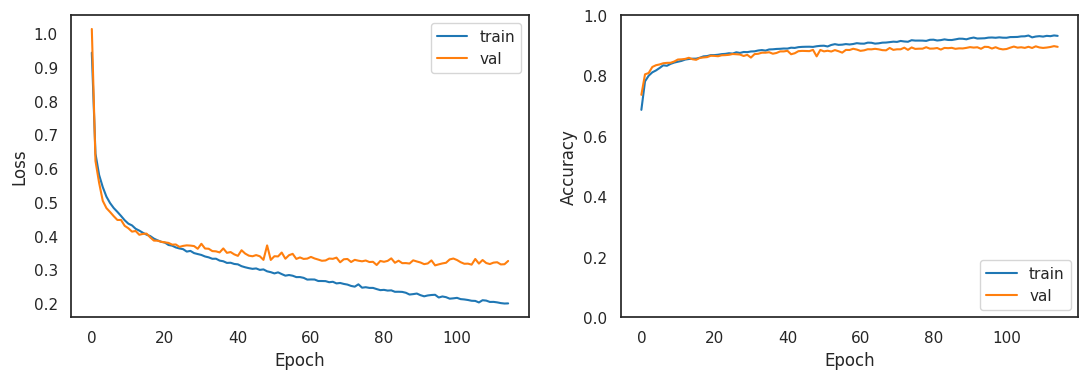

In [ ]:
plt.close('all')
plt.figure(num=1, figsize=(13, 4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.grid('on')


plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.0, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.grid('on')

In [ ]:
"""
# to open tensorboard, on terminal pinpoint to the result folder for the current runs:
    tensorboard --logdir=./results/

#On web browser:
    http://localhost:6006/
"""

'\n# to open tensorboard, on terminal pinpoint to the result folder for the current runs:\n    tensorboard --logdir=./results/\n\n#On web browser:\n    http://localhost:6006/\n'

## Preds

In [ ]:
def convert_from_categorical(y_categorical):
    y_categorical = y_categorical / np.sum(y_categorical, axis=1).reshape((-1,1))
    y = np.argmax(y_categorical, axis=1)
    return y

y_pred_cat = model.predict(x_test)
y_pred = convert_from_categorical(y_pred_cat) 


In [ ]:
y_pred_cat[0,:]

array([1.59921401e-05, 1.21031426e-05, 2.51911006e-05, 2.30849510e-05,
       1.79099472e-04, 4.87374552e-02, 9.50920820e-01, 2.82222190e-05,
       1.17314175e-05, 4.63470024e-05], dtype=float32)

In [ ]:
cf_matrix_cnt = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=m_classnames_id)

temporary_vector = cf_matrix_cnt.sum(axis=1).astype("float"); 
temporary_vector[temporary_vector==0]=np.nan
cf_matrix = cf_matrix_cnt.astype("float")/temporary_vector[:,np.newaxis]


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


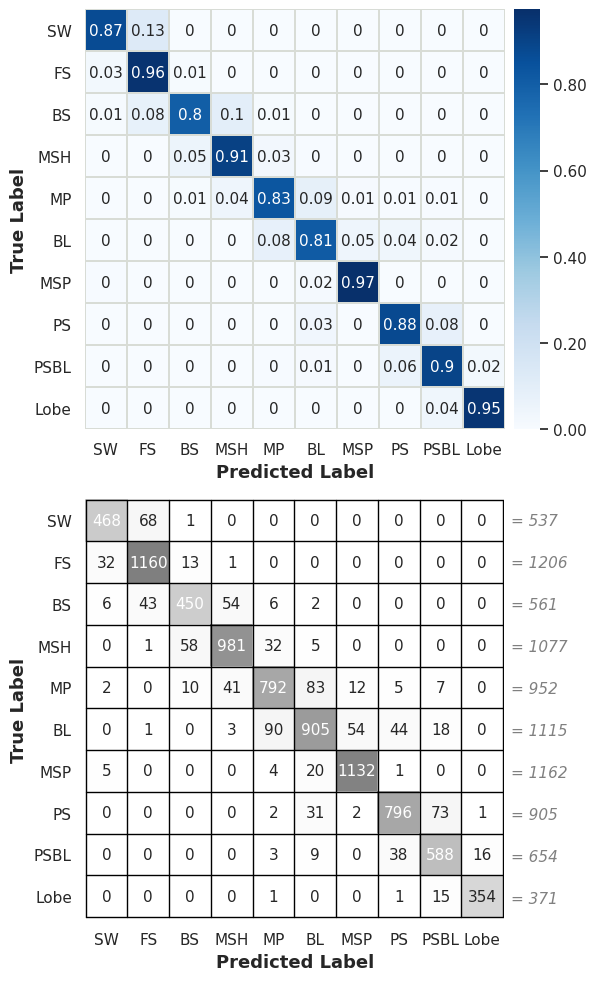

In [ ]:
plt.close('all')
plot_conf_mat(cf_matrix_cnt, cf_matrix, m_classnames, txt_size=11)